Trying to figure out if it's better to just mask RTN pixels

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import math
from math import erf, sqrt
from scipy import special, integrate
from photutils.aperture import CircularAperture

In [4]:
def gaussian_ensq_energy(half_width, sigma_x, sigma_y):
    '''Returns the energy in square of half-width p centered on a Gaussian PSF.

    Parameters
    ----------
    half_width : float
        The half-width of the square, in units of um.
    sigma_x : float
        The standard deviation of the Gaussian in the x direction, in um.
    sigma_y : float
        The standard deviation of the Gaussian in the y direction, in um.

    Returns
    -------
    pix_fraction : float
        The fraction of the light that hits the square.
    '''
    arg_x = half_width / np.sqrt(2) / sigma_x
    arg_y = half_width / np.sqrt(2) / sigma_y
    pix_fraction = special.erf(arg_x) * special.erf(arg_y)
    return pix_fraction

def gaussian_psf(num_pix, resolution, pix_size, mu, sigma):
    '''Return an x-y grid with a Gaussian disk evaluated at each point.

    Parameters
    ----------
    num_pix : int
        The number of pixels in the subarray.
    resolution : int
        The number of subpixels per pixel in the subarray.
    pix_size : float
        The size of each pixel in the subarray, in microns.
    mu : array-like
        The mean of the Gaussian, in microns.
    Sigma : array-like
        The covariance matrix of the Gaussian, in microns^2.

    Returns
    -------
    gaussian : array-like
        The Gaussian PSF evaluated at each point in the subarray,
        normalized to have a total amplitude of the fractional energy
        ensquared in the subarray.
    '''
    grid_points = num_pix * resolution
    x = np.linspace(-num_pix / 2.0, num_pix / 2.0, grid_points) * pix_size
    y = np.linspace(-num_pix / 2.0, num_pix / 2.0, grid_points) * pix_size
    x, y = np.meshgrid(x, y)
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y

    sigma_inv = np.linalg.inv(sigma)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    arg = np.einsum('...k,kl,...l->...', pos-mu, sigma_inv, pos-mu)
    # Determine the fraction of the light that hits the entire subarray
    array_p = num_pix / 2 * pix_size
    subarray_fraction = gaussian_ensq_energy(array_p, np.sqrt(sigma[0][0]), np.sqrt(sigma[1][1]))
    # Normalize the PSF to have a total amplitude of subarray_fraction
    gaussian = np.exp(-arg / 2)
    normalize = subarray_fraction / gaussian.sum()
    return gaussian * normalize

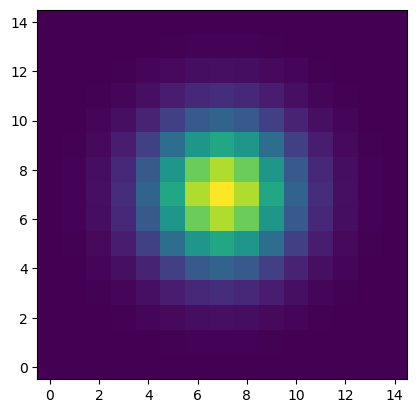

In [5]:
num_pix = 15
pix_size = 5
mu = [0, 0]
fwhm = 5 * pix_size
sigma = (fwhm / (2 * math.sqrt(2 * math.log(2))))
sigma_arr = [[sigma ** 2, 0], [0, sigma ** 2]]
psf = gaussian_psf(num_pix, resolution=1, pix_size=pix_size, mu=mu,
                   sigma=sigma_arr)
plt.imshow(psf, origin='lower', cmap='viridis')
plt.show()
max_phot = 10  # Max electrons per frame in central pixel
multiplier = max_phot / np.max(psf)
frame = psf * multiplier

In [ ]:
frac_rtn_pix = 0.1  # Fraction of pixels affected by RTN
sigma_no_rtn = 1
sigma_rtn = 3
sigma_rtn_corrected = 2

10.0


In [42]:
def get_snr_options_2(frame, frac_rtn_pix, sigma_no_rtn, sigma_rtn, aper_radius_guess=5, sigma_rtn_corrected=None, random_seed=42):
    # First create a frame mask of RTN pixels using binomial distribution
    np.random.seed(random_seed)
    rtn_mask = 1 - np.random.binomial(1, frac_rtn_pix, size=frame.shape)
    pix_noise_vals = np.where(rtn_mask == 0, sigma_rtn, sigma_no_rtn)
    if sigma_rtn_corrected is None:
        sigma_rtn_corrected = sigma_no_rtn
    pix_noise_vals_corr = sigma_rtn_corrected * np.ones_like(frame)
    # snr = 0
    # aper_radius = aper_radius_guess
    # Find maximum SNR by varying aper_radius
    aperture = CircularAperture((num_pix//2, num_pix//2), r=aper_radius_guess)
    aperture_weights = aperture.to_mask(method='exact').to_image(frame.shape)
    aperture_weights_masked = aperture_weights * rtn_mask
    flux = np.sum(frame * aperture_weights)
    flux_masked = np.sum(frame * aperture_weights_masked)
    read_var = np.sum(pix_noise_vals ** 2 * aperture_weights)
    read_var_corr = np.sum(pix_noise_vals_corr ** 2 * aperture_weights)
    read_var_masked = np.sum(pix_noise_vals ** 2 * aperture_weights_masked)
    tot_noise = np.sqrt(flux + read_var)
    tot_noise_corr = np.sqrt(flux + read_var_corr)
    tot_noise_masked = np.sqrt(flux_masked + read_var_masked)
    snr = flux / tot_noise
    snr_corr = flux / tot_noise_corr
    snr_masked = flux_masked / tot_noise_masked
    return snr, snr_corr, snr_masked
    # flux = aperture.do_photometry(frame, method='exact')[0][0]
    # Use photutils to create a circular aperture
    

get_snr_options_2(frame, frac_rtn_pix, sigma_no_rtn, sigma_rtn, aper_radius_guess=5, random_seed=41)

(12.744171789415567, 13.297926320286704, 13.217564318378447)

In [206]:
def get_snr_options(frame, frac_rtn_pix, sigma_no_rtn, sigma_rtn, sigma_rtn_corrected=None, random_seed=42):
    # Get optimal aperture for all cases
    np.random.seed(random_seed)
    signal_rtn_uncorrected = 0
    signal_rtn_masked = 0
    signal_rtn_corrected = 0
    noise_rtn_uncorrected = 0
    noise_rtn_masked = 0
    noise_rtn_corrected = 0
    snr_rtn_uncorrected = 0
    snr_rtn_masked = 0
    snr_rtn_corrected = 0
    n_aper_uncorrected = 0
    n_aper_masked = 0
    n_aper_corrected = 0
    uncorrected_aper_found = False
    masked_aper_found = False
    corrected_aper_found = False
    func_grid = frame.copy()
    if sigma_rtn_corrected is None:
        sigma_rtn_corrected = sigma_no_rtn
    for i in range(num_pix ** 2):
        imax, jmax = np.unravel_index(func_grid.argmax(), func_grid.shape)
        max_sig_remaining = frame[imax, jmax]
        func_grid[imax, jmax] = -1
        # Randomly decide if this pixel is RTN-affected
        if np.random.rand() < frac_rtn_pix:
            is_rtn = True
            pix_read_noise = sigma_rtn
        else:
            is_rtn = False
            pix_read_noise = sigma_no_rtn
        if not uncorrected_aper_found:
            signal_rtn_uncorrected += max_sig_remaining
            noise_rtn_uncorrected = np.sqrt(noise_rtn_uncorrected ** 2 + max_sig_remaining + pix_read_noise ** 2)
            new_snr_rtn_uncorrected = signal_rtn_uncorrected / noise_rtn_uncorrected
            if new_snr_rtn_uncorrected < snr_rtn_uncorrected:
                # uncorrected_aper_found = True
                pass
            else:
                snr_rtn_uncorrected = new_snr_rtn_uncorrected
                n_aper_uncorrected += 1
        if not masked_aper_found:
            if is_rtn:
                pass
            else:
                signal_rtn_masked += max_sig_remaining
                noise_rtn_masked = np.sqrt(noise_rtn_masked ** 2 + max_sig_remaining + pix_read_noise ** 2)
                new_snr_rtn_masked = signal_rtn_masked / noise_rtn_masked
                if new_snr_rtn_masked < snr_rtn_masked:
                    masked_aper_found = True
                else:
                    snr_rtn_masked = new_snr_rtn_masked
                    n_aper_masked += 1
        if not corrected_aper_found:
            if is_rtn:
                pix_read_noise = sigma_rtn_corrected
            signal_rtn_corrected += max_sig_remaining
            noise_rtn_corrected = np.sqrt(noise_rtn_corrected ** 2 + max_sig_remaining + pix_read_noise ** 2)
            new_snr_rtn_corrected = signal_rtn_corrected / noise_rtn_corrected
            if new_snr_rtn_corrected < snr_rtn_corrected:
                # corrected_aper_found = True
                pass
            else:
                snr_rtn_corrected = new_snr_rtn_corrected
                n_aper_corrected += 1
        if (uncorrected_aper_found and
            masked_aper_found and
            corrected_aper_found):
            break
    return {'signal_uncorrected': signal_rtn_uncorrected,
            'snr_uncorrected': snr_rtn_uncorrected,
            'n_aper_uncorrected': n_aper_uncorrected,
            'signal_masked': signal_rtn_masked,
            'snr_masked': snr_rtn_masked,
            'n_aper_masked': n_aper_masked,
            'signal_corrected': signal_rtn_corrected,
            'snr_corrected': snr_rtn_corrected,
            'n_aper_corrected': n_aper_corrected}

results_dict = get_snr_options(frame, frac_rtn_pix, sigma_no_rtn, sigma_rtn, random_seed=41)
print(results_dict['signal_uncorrected'], results_dict['snr_uncorrected'], results_dict['n_aper_uncorrected'])
print(results_dict['signal_masked'], results_dict['snr_masked'], results_dict['n_aper_masked'])
print(results_dict['signal_corrected'], results_dict['snr_corrected'], results_dict['n_aper_corrected'])
print(results_dict['snr_masked'] / results_dict['snr_uncorrected'], results_dict['snr_corrected'] / results_dict['snr_uncorrected'])

246.69711697164317 12.675237662922395 61
206.08797698164767 12.524457681483632 64
246.69711697164317 13.37781235063101 69
0.9881043665256215 1.0554289163164006


In [207]:
def get_snr_options_mc(frame, frac_rtn_pix, sigma_no_rtn, sigma_rtn, sigma_rtn_corrected=None, n_trials=100):
    snr_uncorrected_list = np.zeros(n_trials)
    snr_masked_list = np.zeros(n_trials)
    snr_corrected_list = np.zeros(n_trials)
    for i in range(n_trials):
        results_dict = get_snr_options(frame, frac_rtn_pix, sigma_no_rtn, sigma_rtn, sigma_rtn_corrected, random_seed=42 + i)
        snr_uncorrected_list[i] = results_dict['snr_uncorrected']
        snr_masked_list[i] = results_dict['snr_masked']
        snr_corrected_list[i] = results_dict['snr_corrected']
    snr_uncorrected_avg = np.mean(snr_uncorrected_list)
    snr_masked_avg = np.mean(snr_masked_list)
    snr_corrected_avg = np.mean(snr_corrected_list)
    return {'snr_uncorrected_avg': snr_uncorrected_avg,
            'snr_masked_avg': snr_masked_avg,
            'snr_corrected_avg': snr_corrected_avg}

In [210]:
rtn_frac_list = np.linspace(0, 0.15, 20)
snr_ratio_masked = np.zeros_like(rtn_frac_list)
snr_ratio_corrected = np.zeros_like(rtn_frac_list)
for i, frac_rtn_pix in enumerate(rtn_frac_list):
    results_dict = get_snr_options_mc(frame, frac_rtn_pix, sigma_no_rtn, sigma_rtn, sigma_rtn_corrected, n_trials=100)
    snr_ratio_masked[i] = results_dict['snr_masked_avg'] / results_dict['snr_uncorrected_avg']
    snr_ratio_corrected[i] = results_dict['snr_corrected_avg'] / results_dict['snr_uncorrected_avg']

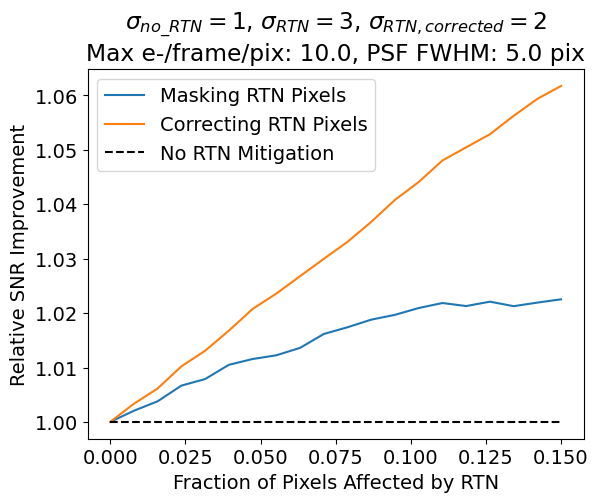

In [211]:
plt.rcParams.update({'font.size': 14})
plt.plot(rtn_frac_list, snr_ratio_masked, label='Masking RTN Pixels')
plt.plot(rtn_frac_list, snr_ratio_corrected, label='Correcting RTN Pixels')
plt.plot(rtn_frac_list, np.ones_like(rtn_frac_list), 'k--', label='No RTN Mitigation')
plt.xlabel("Fraction of Pixels Affected by RTN")
plt.ylabel("Relative SNR Improvement")
plt.title(r'$\sigma_{no\_RTN}=$' + f'{sigma_no_rtn}, ' +
          r'$\sigma_{RTN}=$' + f'{sigma_rtn}' + 
          r', $\sigma_{RTN, corrected}=$' + f'{sigma_rtn_corrected}' +
          '\nMax e-/frame/pix: ' + f'{frame.max()}' + 
          ', PSF FWHM: ' + f'{fwhm / pix_size} pix')
plt.legend()
plt.show()